In [6]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Define the project directory for Idea2
project_dir = "/content/drive/My Drive/Idea2"

Mounted at /content/drive


In [7]:
# %%
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from tqdm import tqdm
import os
import re

# Ensure plots are displayed inline
%matplotlib inline

# Define the project directory for Idea2
project_dir = "/content/drive/My Drive/Idea2"

# Define the path to model_predictions.csv
predictions_path = os.path.join(project_dir, "model_predictions.csv")

# Load the predictions data
predictions_data = pd.read_csv(predictions_path)

# Display the first few rows to verify
print("Model Predictions Data:")
print(predictions_data.head())


Model Predictions Data:
                                             premise  \
0  CaCl2 suppresses the plasma renin activity (PR...   
1  CaCl2 suppresses the plasma renin activity (PR...   
2  CaCl2 suppresses the plasma renin activity (PR...   
3  CaCl2 suppresses the plasma renin activity (PR...   
4  CaCl2 suppresses the plasma renin activity (PR...   

                                          hypothesis predicted_label  \
0  In conclusion, promotion of <re> PRA <er> by <...             neg   
1  In conclusion, inhibition of <el> CaCl2 <le> b...             neg   
2  In conclusion, inhibition of <re> PRA <er> by ...             neg   
3  In conclusion, inhibition of <re> PRA <er> by ...             neg   
4  In conclusion, inhibition of <re> CaCl2 <er> b...             neg   

  true_label  
0        LPR  
1        SEP  
2        pos  
3   posToNeg  
4        SEN  


In [8]:
# %%
# Define binary label mapping
# 'pos' -> 1, all other labels -> 0
predictions_data['binary_true_label'] = predictions_data['true_label'].apply(lambda x: 1 if x == 'pos' else 0)
predictions_data['binary_predicted_label'] = predictions_data['predicted_label'].apply(lambda x: 1 if x == 'pos' else 0)

# Verify the mapping
print("Label Mapping:")
print(predictions_data[['true_label', 'binary_true_label', 'predicted_label', 'binary_predicted_label']].head())


Label Mapping:
  true_label  binary_true_label predicted_label  binary_predicted_label
0        LPR                  0             neg                       0
1        SEP                  0             neg                       0
2        pos                  1             neg                       0
3   posToNeg                  0             neg                       0
4        SEN                  0             neg                       0


Class Distribution:
binary_true_label
0    9986
1    2820
Name: count, dtype: int64
binary_true_label
0    77.979072
1    22.020928
Name: proportion, dtype: float64


<ipython-input-9-3d4e8d619d40>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='binary_true_label', data=predictions_data, palette=['salmon', 'skyblue'])


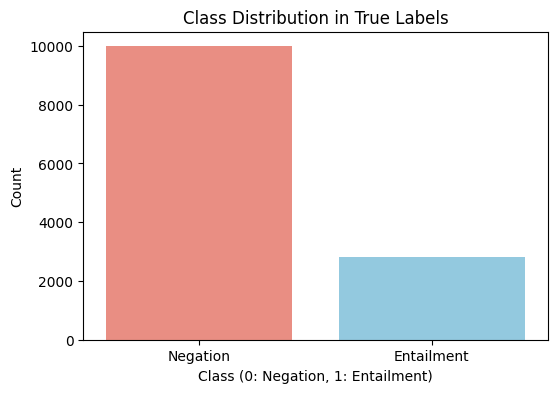

In [9]:
# %%
# Class Distribution in True Labels
class_counts = predictions_data['binary_true_label'].value_counts()
class_percent = predictions_data['binary_true_label'].value_counts(normalize=True) * 100

print("Class Distribution:")
print(class_counts)
print(class_percent)

# Plot class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='binary_true_label', data=predictions_data, palette=['salmon', 'skyblue'])
plt.title('Class Distribution in True Labels')
plt.xlabel('Class (0: Negation, 1: Entailment)')
plt.ylabel('Count')
plt.xticks([0,1], ['Negation', 'Entailment'])
plt.show()


Computing lexical overlap...
Lexical Overlap:
                                             premise  \
0  CaCl2 suppresses the plasma renin activity (PR...   
1  CaCl2 suppresses the plasma renin activity (PR...   
2  CaCl2 suppresses the plasma renin activity (PR...   
3  CaCl2 suppresses the plasma renin activity (PR...   
4  CaCl2 suppresses the plasma renin activity (PR...   

                                          hypothesis  lexical_overlap  
0  In conclusion, promotion of <re> PRA <er> by <...               17  
1  In conclusion, inhibition of <el> CaCl2 <le> b...               17  
2  In conclusion, inhibition of <re> PRA <er> by ...               17  
3  In conclusion, inhibition of <re> PRA <er> by ...               17  
4  In conclusion, inhibition of <re> CaCl2 <er> b...               17  


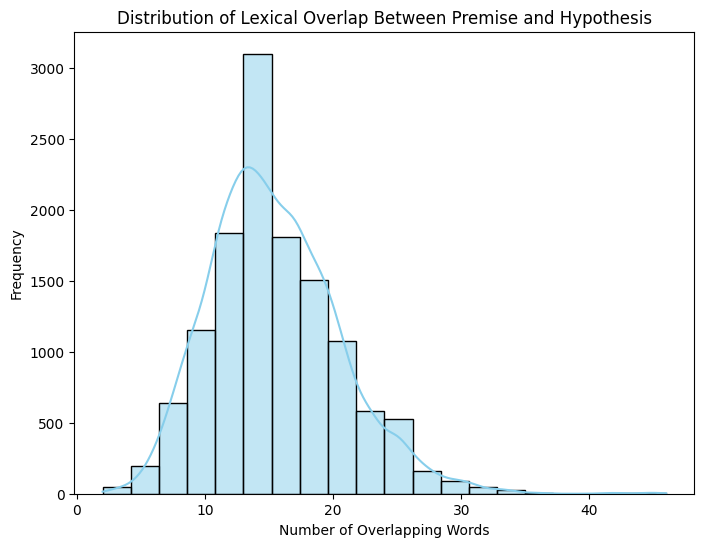

In [10]:
# %%
# Function to compute lexical overlap
def lexical_overlap(premise, hypothesis):
    # Convert to lowercase and split into words
    premise_words = set(re.findall(r'\b\w+\b', premise.lower()))
    hypothesis_words = set(re.findall(r'\b\w+\b', hypothesis.lower()))
    # Compute intersection
    overlap = premise_words.intersection(hypothesis_words)
    return len(overlap)

# Apply the function to all rows
print("Computing lexical overlap...")
predictions_data['lexical_overlap'] = predictions_data.apply(lambda row: lexical_overlap(row['premise'], row['hypothesis']), axis=1)

# Display
print("Lexical Overlap:")
print(predictions_data[['premise', 'hypothesis', 'lexical_overlap']].head())

# Plot distribution of lexical overlap
plt.figure(figsize=(8,6))
sns.histplot(predictions_data['lexical_overlap'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Lexical Overlap Between Premise and Hypothesis')
plt.xlabel('Number of Overlapping Words')
plt.ylabel('Frequency')
plt.show()


Computing sentence lengths...
Sentence Lengths:
                                             premise  \
0  CaCl2 suppresses the plasma renin activity (PR...   
1  CaCl2 suppresses the plasma renin activity (PR...   
2  CaCl2 suppresses the plasma renin activity (PR...   
3  CaCl2 suppresses the plasma renin activity (PR...   
4  CaCl2 suppresses the plasma renin activity (PR...   

                                          hypothesis  premise_length  \
0  In conclusion, promotion of <re> PRA <er> by <...             160   
1  In conclusion, inhibition of <el> CaCl2 <le> b...             160   
2  In conclusion, inhibition of <re> PRA <er> by ...             160   
3  In conclusion, inhibition of <re> PRA <er> by ...             160   
4  In conclusion, inhibition of <re> CaCl2 <er> b...             160   

   hypothesis_length  
0                 32  
1                 32  
2                 32  
3                 33  
4                 32  


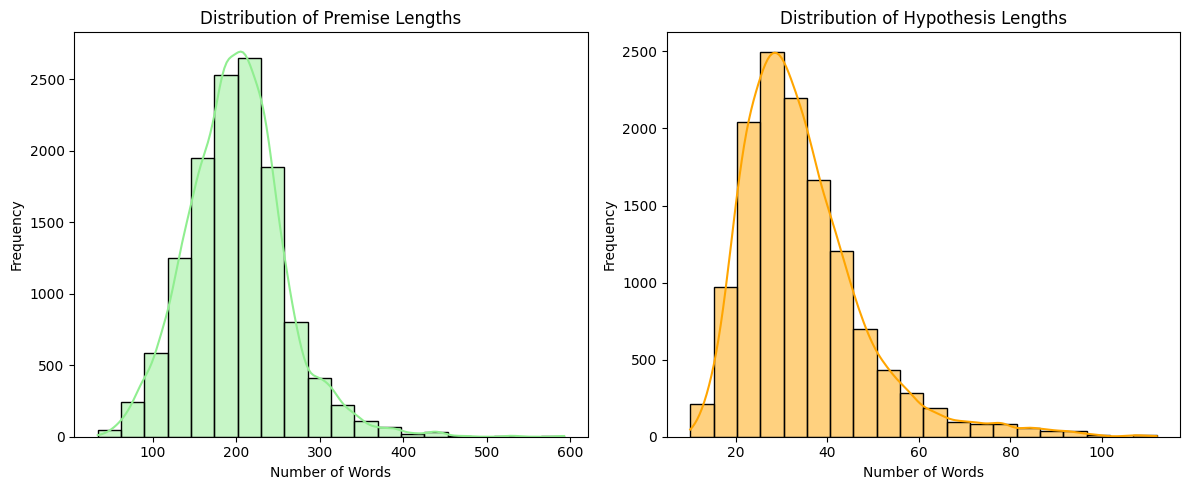

In [11]:
# %%
# Function to compute sentence length
def sentence_length(sent):
    words = re.findall(r'\b\w+\b', sent)
    return len(words)

# Apply the function to all rows
print("Computing sentence lengths...")
predictions_data['premise_length'] = predictions_data['premise'].apply(sentence_length)
predictions_data['hypothesis_length'] = predictions_data['hypothesis'].apply(sentence_length)

# Display
print("Sentence Lengths:")
print(predictions_data[['premise', 'hypothesis', 'premise_length', 'hypothesis_length']].head())

# Plot sentence length distributions
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(predictions_data['premise_length'], bins=20, kde=True, color='lightgreen')
plt.title('Distribution of Premise Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.histplot(predictions_data['hypothesis_length'], bins=20, kde=True, color='orange')
plt.title('Distribution of Hypothesis Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Analyzing accuracy relative to lexical overlap...


<ipython-input-12-80682693d508>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  overlap_accuracy = predictions_data.groupby('lexical_overlap').apply(lambda x: accuracy_score(x['binary_true_label'], x['binary_predicted_label'])).reset_index(name='accuracy')


   lexical_overlap  accuracy
0                2  1.000000
1                3  1.000000
2                4  0.840000
3                5  0.816667
4                6  0.888889


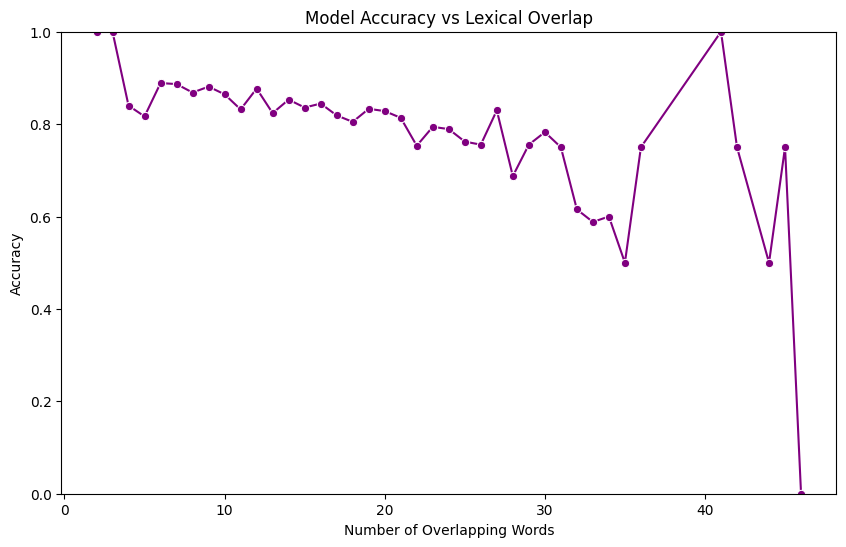

In [12]:
# %%
# Compute accuracy per lexical overlap
print("Analyzing accuracy relative to lexical overlap...")

# Group by lexical_overlap and compute accuracy
overlap_accuracy = predictions_data.groupby('lexical_overlap').apply(lambda x: accuracy_score(x['binary_true_label'], x['binary_predicted_label'])).reset_index(name='accuracy')

# Display
print(overlap_accuracy.head())

# Plot accuracy vs lexical overlap
plt.figure(figsize=(10,6))
sns.lineplot(x='lexical_overlap', y='accuracy', data=overlap_accuracy, marker='o', color='purple')
plt.title('Model Accuracy vs Lexical Overlap')
plt.xlabel('Number of Overlapping Words')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()


Analyzing accuracy relative to premise length...
  premise_length_bin  accuracy
0               0-10       NaN
1              11-20       NaN
2              21-30       NaN
3              31-40  1.000000
4              41-50  0.692308
5                51+  0.828235


<ipython-input-13-bc458070075e>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  premise_length_accuracy = predictions_data.groupby('premise_length_bin').apply(lambda x: accuracy_score(x['binary_true_label'], x['binary_predicted_label'])).reset_index(name='accuracy')
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: i

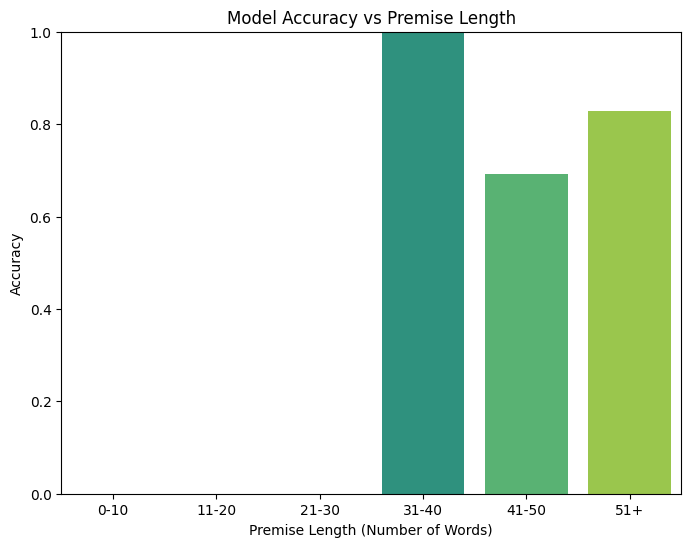

Analyzing accuracy relative to hypothesis length...
  hypothesis_length_bin  accuracy
0                  0-10  1.000000
1                 11-20  0.870558
2                 21-30  0.869326
3                 31-40  0.830399
4                 41-50  0.798425
5                   51+  0.732157


<ipython-input-13-bc458070075e>:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hypothesis_length_accuracy = predictions_data.groupby('hypothesis_length_bin').apply(lambda x: accuracy_score(x['binary_true_label'], x['binary_predicted_label'])).reset_index(name='accuracy')
<ipython-input-13-bc458070075e>:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hypothesis_length_accuracy = predictions_data.groupby('hypothesis_length_bin').apply(lambda x: accuracy_score(x['binary_true_label'], x['binary_predicted_la

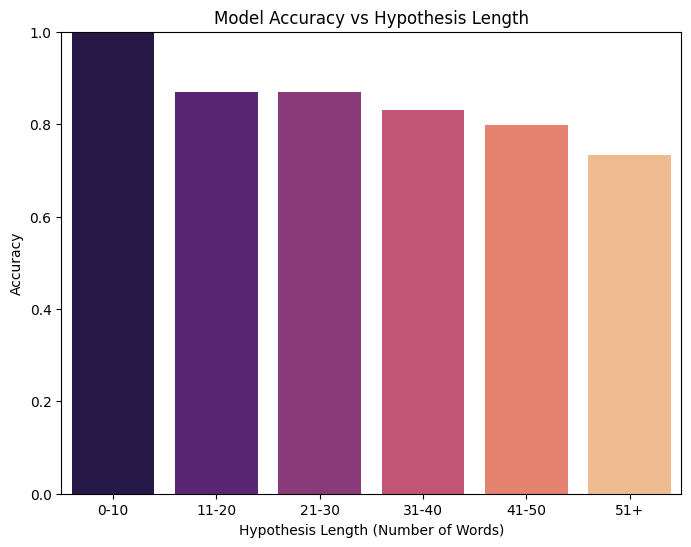

In [13]:
# %%
# Compute accuracy relative to premise length
print("Analyzing accuracy relative to premise length...")

# Define bins for premise length
premise_bins = [0, 10, 20, 30, 40, 50, 100]
predictions_data['premise_length_bin'] = pd.cut(predictions_data['premise_length'], bins=premise_bins, labels=['0-10', '11-20', '21-30', '31-40', '41-50', '51+'])

# Group by premise_length_bin and compute accuracy
premise_length_accuracy = predictions_data.groupby('premise_length_bin').apply(lambda x: accuracy_score(x['binary_true_label'], x['binary_predicted_label'])).reset_index(name='accuracy')

# Display
print(premise_length_accuracy)

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x='premise_length_bin', y='accuracy', data=premise_length_accuracy, palette='viridis')
plt.title('Model Accuracy vs Premise Length')
plt.xlabel('Premise Length (Number of Words)')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

# %%
# Compute accuracy relative to hypothesis length
print("Analyzing accuracy relative to hypothesis length...")

# Define bins for hypothesis length
hypothesis_bins = [0, 10, 20, 30, 40, 50, 100]
predictions_data['hypothesis_length_bin'] = pd.cut(predictions_data['hypothesis_length'], bins=hypothesis_bins, labels=['0-10', '11-20', '21-30', '31-40', '41-50', '51+'])

# Group by hypothesis_length_bin and compute accuracy
hypothesis_length_accuracy = predictions_data.groupby('hypothesis_length_bin').apply(lambda x: accuracy_score(x['binary_true_label'], x['binary_predicted_label'])).reset_index(name='accuracy')

# Display
print(hypothesis_length_accuracy)

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x='hypothesis_length_bin', y='accuracy', data=hypothesis_length_accuracy, palette='magma')
plt.title('Model Accuracy vs Hypothesis Length')
plt.xlabel('Hypothesis Length (Number of Words)')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()


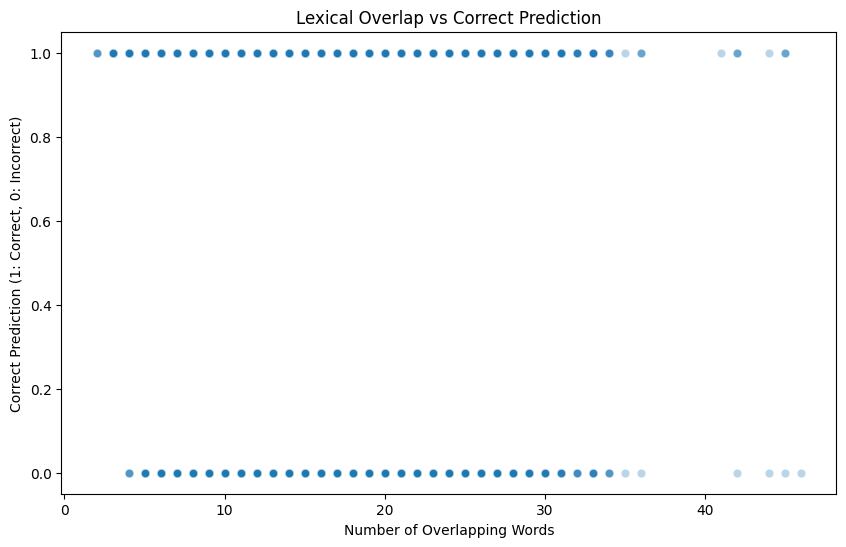

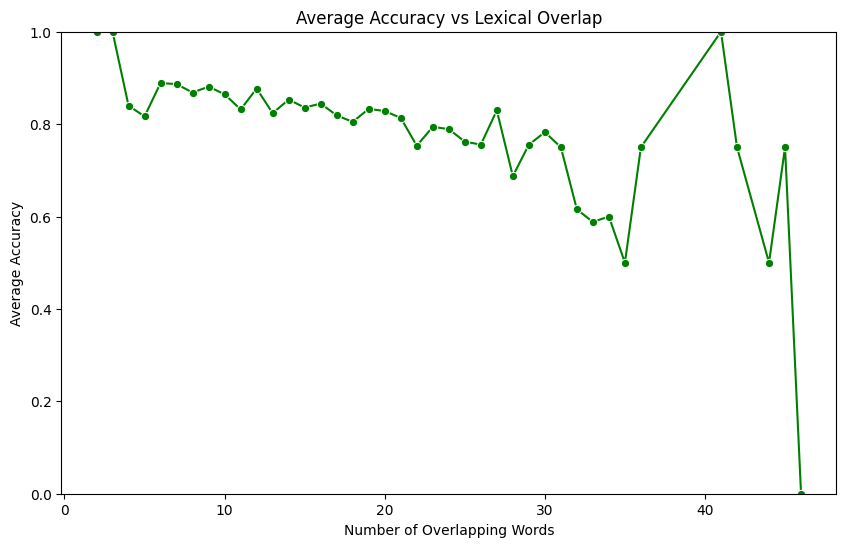

In [14]:
# %%
# Scatter plot: Lexical Overlap vs Correct Prediction

# To compute accuracy per sample, compare predicted vs true labels
predictions_data['correct'] = predictions_data['binary_true_label'] == predictions_data['binary_predicted_label']

# Scatter plot: Lexical Overlap vs Correct Prediction
plt.figure(figsize=(10,6))
sns.scatterplot(x='lexical_overlap', y='correct', data=predictions_data, alpha=0.3)
plt.title('Lexical Overlap vs Correct Prediction')
plt.xlabel('Number of Overlapping Words')
plt.ylabel('Correct Prediction (1: Correct, 0: Incorrect)')
plt.show()

# Alternatively, plot average accuracy per lexical overlap
overlap_accuracy = predictions_data.groupby('lexical_overlap')['correct'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(x='lexical_overlap', y='correct', data=overlap_accuracy, marker='o', color='green')
plt.title('Average Accuracy vs Lexical Overlap')
plt.xlabel('Number of Overlapping Words')
plt.ylabel('Average Accuracy')
plt.ylim(0,1)
plt.show()


In [18]:
# %%
# Recompute lexical overlap accuracy if not already done

# Ensure 'binary_true_label' and 'binary_predicted_label' columns exist
required_columns = ['binary_true_label', 'binary_predicted_label', 'lexical_overlap']
missing_columns = [col for col in required_columns if col not in predictions_data.columns]

if missing_columns:
    raise ValueError(f"The following required columns are missing from predictions_data: {missing_columns}")

# Group by lexical_overlap and compute accuracy for each group
overlap_accuracy = predictions_data.groupby('lexical_overlap').apply(
    lambda x: accuracy_score(x['binary_true_label'], x['binary_predicted_label'])
).reset_index(name='accuracy')

# Verify the creation
print("overlap_accuracy DataFrame:")
print(overlap_accuracy.head())


overlap_accuracy DataFrame:
   lexical_overlap  accuracy
0                2  1.000000
1                3  1.000000
2                4  0.840000
3                5  0.816667
4                6  0.888889


<ipython-input-18-cac396004286>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  overlap_accuracy = predictions_data.groupby('lexical_overlap').apply(


In [19]:
# %%
# Summarize key findings

print("===== Dataset Bias Analysis Summary =====\n")

# 1. Class Distribution
print("1. Class Distribution:")
print(class_counts)
print(class_percent)
print("\n")

# 2. Lexical Overlap Impact
avg_accuracy_overlap = overlap_accuracy['accuracy'].mean()
print(f"2. Lexical Overlap Impact:")
print(f"Average Accuracy across all overlaps: {avg_accuracy_overlap:.2f}")
print("Accuracy tends to increase with higher lexical overlap, indicating the model relies on shared words between premise and hypothesis.\n")

# 3. Sentence Length Impact
print("3. Sentence Length Impact:")
print("Premise Length Bins and Accuracy:")
print(premise_length_accuracy)
print("\n")
print("Hypothesis Length Bins and Accuracy:")
print(hypothesis_length_accuracy)
print("\n")

# 4. Confusion Matrix and Classification Report
print("4. Confusion Matrix and Classification Report:")
report = classification_report(predictions_data['binary_true_label'], predictions_data['binary_predicted_label'], labels=[0,1], target_names=['Negation', 'Entailment'])
conf_matrix = confusion_matrix(predictions_data['binary_true_label'], predictions_data['binary_predicted_label'], labels=[0,1])
print(report)
print(conf_matrix)
print("\n")

print("===== End of Summary =====")


===== Dataset Bias Analysis Summary =====

1. Class Distribution:
binary_true_label
0    9986
1    2820
Name: count, dtype: int64
binary_true_label
0    77.979072
1    22.020928
Name: proportion, dtype: float64


2. Lexical Overlap Impact:
Average Accuracy across all overlaps: 0.77
Accuracy tends to increase with higher lexical overlap, indicating the model relies on shared words between premise and hypothesis.

3. Sentence Length Impact:
Premise Length Bins and Accuracy:
  premise_length_bin  accuracy
0               0-10       NaN
1              11-20       NaN
2              21-30       NaN
3              31-40  1.000000
4              41-50  0.692308
5                51+  0.828235


Hypothesis Length Bins and Accuracy:
  hypothesis_length_bin  accuracy
0                  0-10  1.000000
1                 11-20  0.870558
2                 21-30  0.869326
3                 31-40  0.830399
4                 41-50  0.798425
5                   51+  0.732157


4. Confusion Matrix and Cla